## VAE

### VQ-VAE

This is an implemention of a Variational autoencoder inspired by the implementation found here: https://keras.io/examples/generative/vq_vae/

It used the same data set (Coins) and structure of the VAE notebook

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

### Vector Quantizer
This layer will replace the output of the encoder $z_e(x)$ with $z_q(x)$ (input of the decoder) by finding the closest vector in the codebook. Here we also add the commitment and codebook loss to the reconstruction loss.

In [2]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = (
            beta  # This parameter is best kept between [0.25, 2] as per the paper.
        )

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)

        commitment_loss = self.beta * tf.reduce_mean(
            (tf.stop_gradient(quantized) - x) ** 2
        )
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

### Encoder / Decoder / VQ-VAE Model

In [3]:
def get_encoder(latent_dim=128):
    encoder_inputs = keras.Input(shape=(128, 128, 3))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 3, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=128):
    latent_inputs = keras.Input(shape=get_encoder().output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(3, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

def get_vqvae(latent_dim=128, num_embeddings=128):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(128, 128, 3))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")

In [4]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)
        self.decoder = get_decoder(self.latent_dim)
        self.encoder = get_encoder(self.latent_dim)
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

### Loading training and test sets

In [5]:
train_ds= tf.keras.preprocessing.image_dataset_from_directory(
  'data/train_new',
    label_mode=None,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(128, 128),
  batch_size=32)

val_ds= tf.keras.preprocessing.image_dataset_from_directory(
  'data/train_new',
    label_mode=None,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(128, 128),
  batch_size=32)

test_ds= tf.keras.preprocessing.image_dataset_from_directory(
  'data/test',
    label_mode=None,
  seed=123,
  image_size=(128, 128),
  batch_size=32)


Found 16344 files belonging to 1 classes.
Using 14710 files for training.
Found 16344 files belonging to 1 classes.
Using 1634 files for validation.
Found 44 files belonging to 1 classes.


In [6]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x: (normalization_layer(x)))
normalized_test_ds= test_ds.map(lambda x: (normalization_layer(x)))
normalized_val = val_ds.map(lambda x: (normalization_layer(x)))
trainer = normalized_ds.cache().prefetch(buffer_size=-1)

### Training

In [ ]:
vqvae_trainer = VQVAETrainer(0.1, latent_dim=128, num_embeddings=64)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01))
#vqvae_trainer.fit(trainer, epochs=30, batch_size=64)

### Loading model

In [7]:
vqvae_trainer = VQVAETrainer(0.1, latent_dim=128, num_embeddings=128)
vqvae_trainer.load_weights('./weights_vq/vae')
trained_vqvae=vqvae_trainer.vqvae

### Prediction
Here we also add noise to $z_d(x)$ before decoding

In [12]:
noise=np.random.normal(0, 0.1, size=(1, 32,32,128))

original_data=[]
vq_data=[]
noise_data=[]

encoder = trained_vqvae.get_layer("encoder")
quantizer = trained_vqvae.get_layer("vector_quantizer")
decoder= trained_vqvae.get_layer("decoder")

for images in train_ds.take(1):
    for i in range(10):
        
        original_data.append(images[i].numpy()/255.)
        reconstruction=trained_vqvae.predict(np.expand_dims(images[i].numpy()/255.,axis=0))  
        vq_data.append(reconstruction[0])

        encoded_outputs = encoder.predict(np.expand_dims(images[i].numpy()/255.,axis=0))
        quantized_output=quantizer(encoded_outputs)
        decoded=decoder.predict(quantized_output+noise)
        noise_data.append(decoded[0])

### Ploting

In [10]:
def show_subplot(original, reconstructed,cc):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed)
    plt.title("VQ-VAE")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(cc)
    plt.title("VQ-VAE with noise")
    plt.axis("off")

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


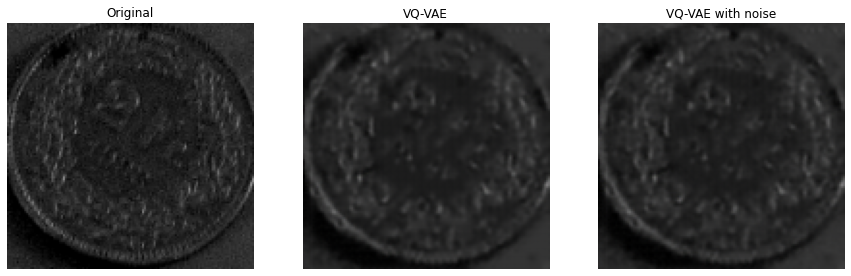

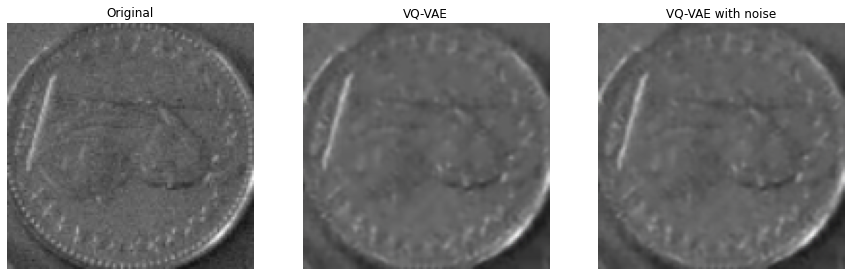

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


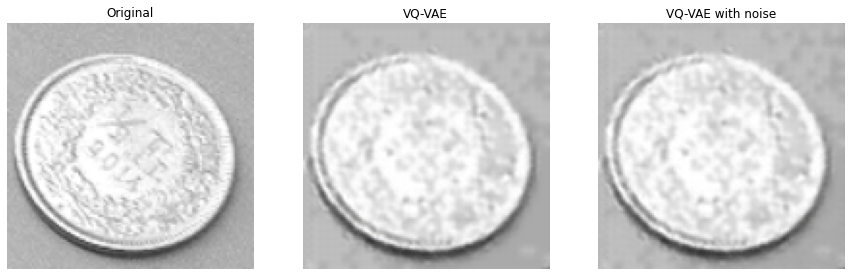

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


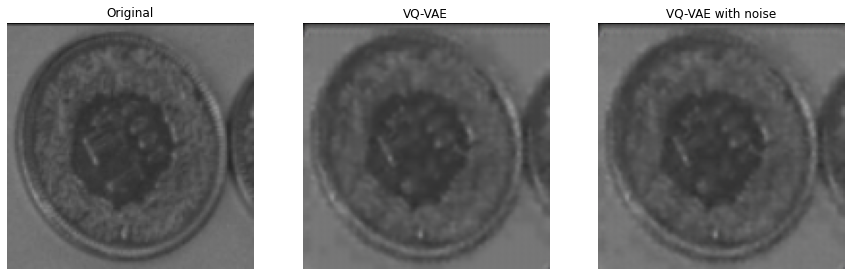

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


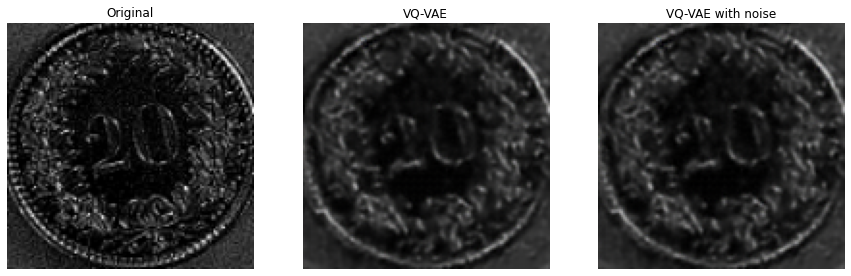

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


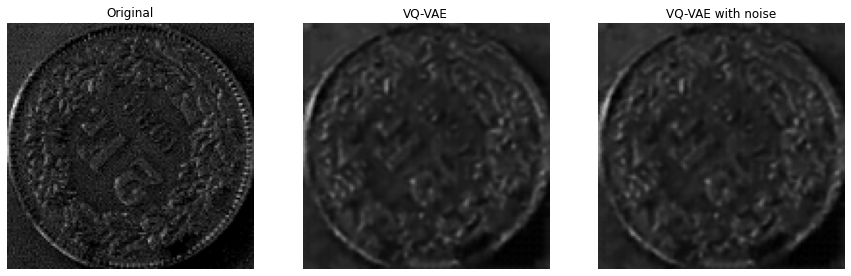

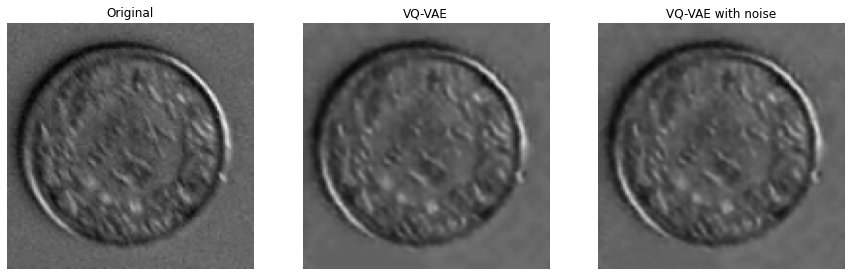

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


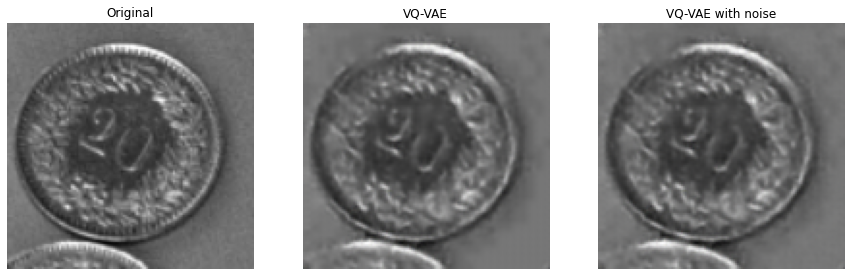

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


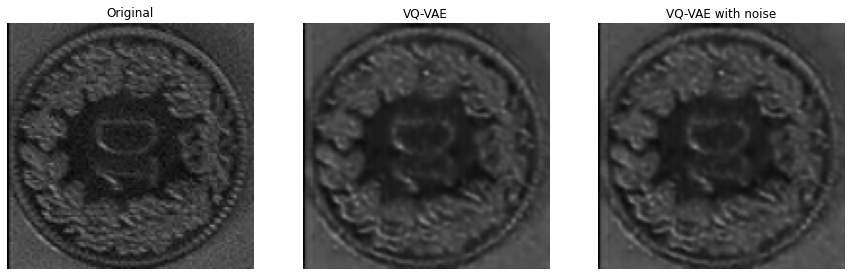

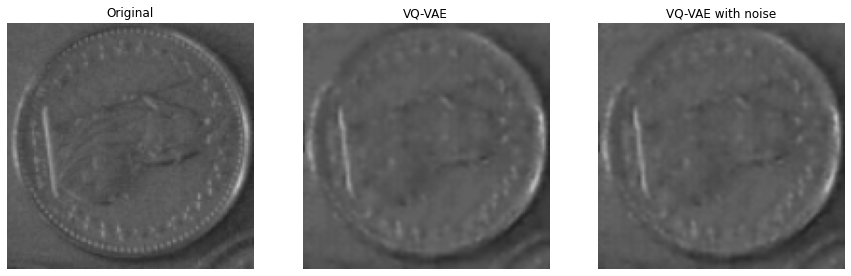

In [11]:
# Train
for original, reconstructed_image,noisy in zip(original_data, vq_data,noise_data):
    show_subplot(original, reconstructed_image,noisy)

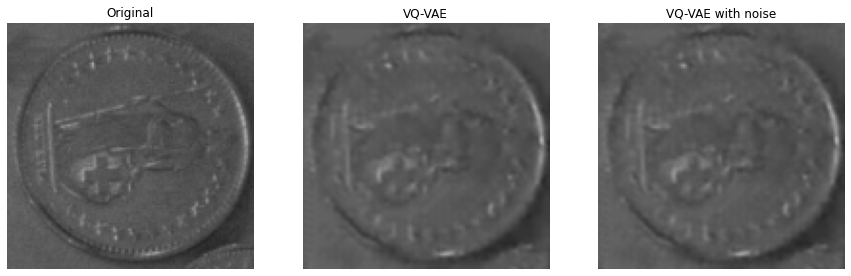

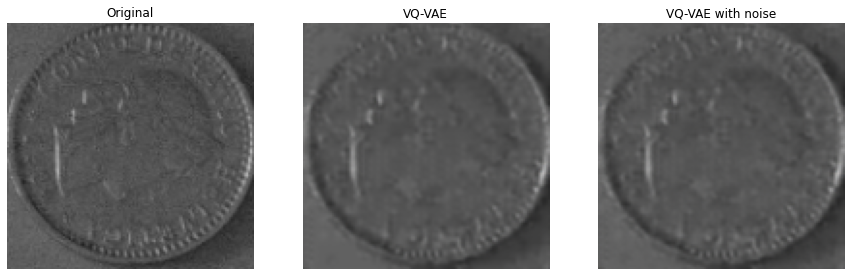

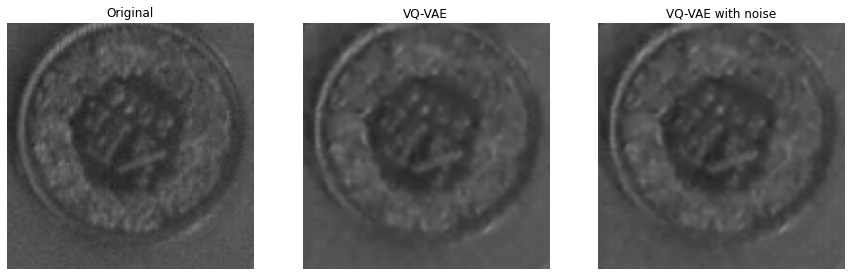

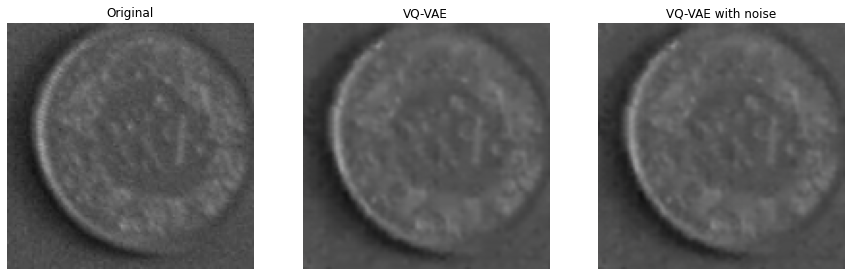

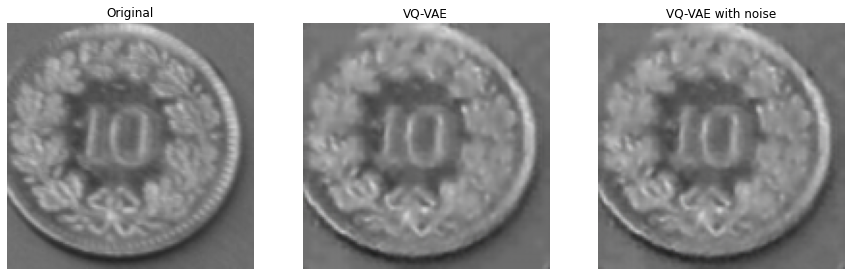

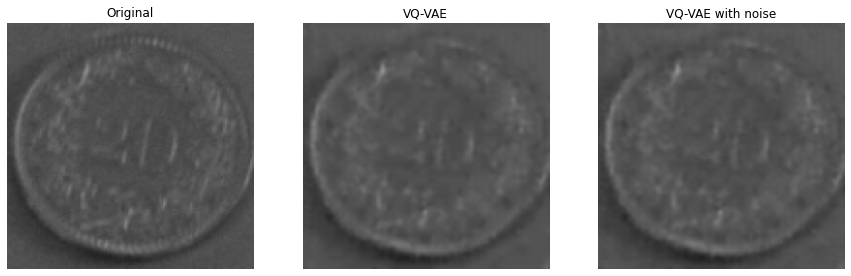

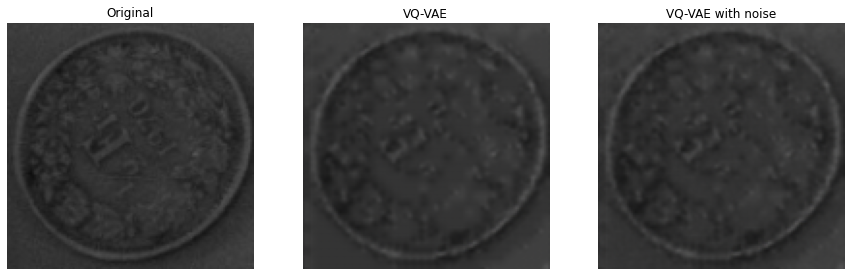

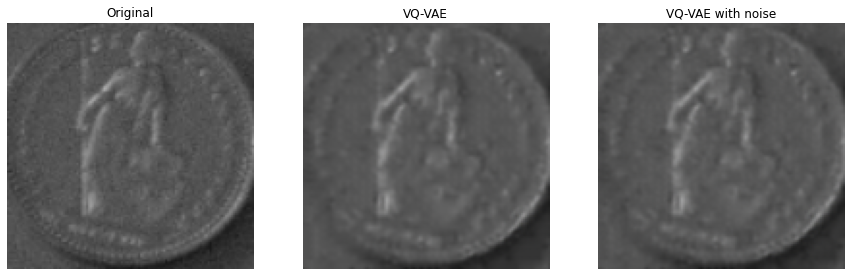

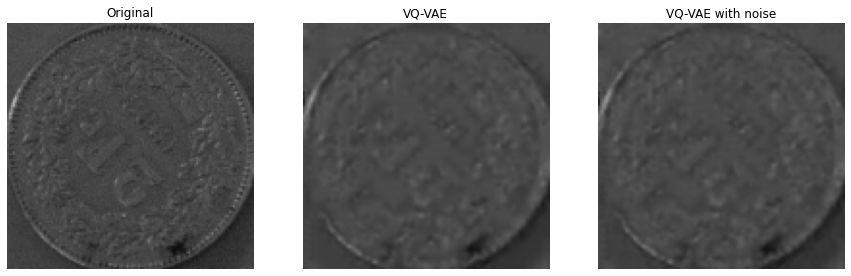

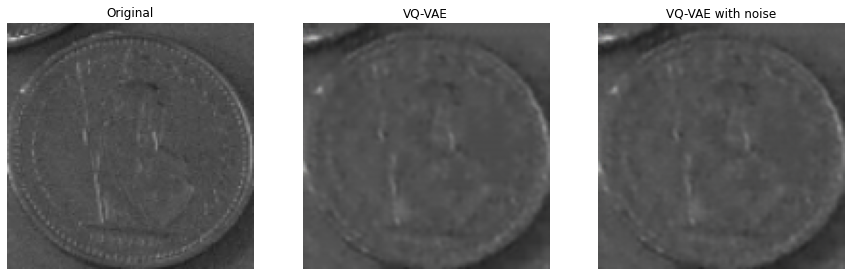

In [13]:
# Test
for original, reconstructed_image,noisy in zip(original_data, vq_data,noise_data):
    show_subplot(original, reconstructed_image,noisy)

We get much better reconstructions compared to a VAE. Also reconstructions on training and test samples yield similar results.